# **Tarefa 3 - Árvore de decisão**

#### **Dicas:**

- Tutorial para iniciantes em Python: https://www.datacamp.com/cheat-sheet/getting-started-with-python-cheat-sheet

- Documentação do pandas: https://colab.research.google.com/drive/1a4sbKG7jOJGn4oeonQPA8XjJm7OYgcdX

- Documentação do scikit-learn: https://scikit-learn.org/stable/

- Documentação do matplotlib: https://matplotlib.org/stable/index.html

- Documentação do seaborn: https://seaborn.pydata.org/tutorial.html

---
## **Dataset:**

Nesse dataset os dados estão relacionados com campanhas de marketing direto (telefonemas) de uma instituição bancária portuguesa. O objetivo da classificação é prever se o cliente irá subscrever um depósito a prazo (**feature y**).


---


**Colunas:**

1 - **age**

2 - **education**

3 - **default**: tem crédito em atraso?

4 - **balance**: saldo médio anual, em euros

5 - **housing**: tem empréstimo para habitação?

6 - **loan**: tem empréstimo pessoal?

7 - **contact**: tipo de comunicação de contato

8 - **day**: último dia de contato do mês

9 - **month**: último mês de contato do ano

10 - **campaign**: número de contatos realizados durante esta campanha e para este cliente

11 - **previous**: número de contatos realizados antes desta campanha e para este cliente

12 - **poutcome**: resultado da campanha de marketing anterior

13 - **y** - o cliente subscreveu um depósito a prazo?

## **Importe os pacotes**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder


## **Crie os datasets**
### **Crie um DataFrame a partir do arquivo de dados disponibilizados no EaD**

**Dicas:**

* Certifique-se que os arquivos a serem lidos estão carregados na sua sessão do Colab, ou em um drive previamente montado, e ajuste o comando para incluir todo o caminho até cada um dos arquivos a serem lidos.

In [2]:
df = pd.read_csv("bank.csv")
print(df.head())
print(df.education.value_counts())
print(df.month.value_counts())
print(df.contact.unique())
print(df.poutcome.value_counts())
print(df.y.value_counts())

df.describe()

   age  education default  balance housing loan   contact  day month  \
0   23  secondary      no      567     yes  yes  cellular   15   may   
1   35  secondary      no        0     yes   no  cellular   17   apr   
2   42  secondary      no      400     yes   no  cellular    3   feb   
3   35    primary      no      793     yes   no  cellular   17   apr   
4   45  secondary      no     1723      no   no  cellular    1   jun   

   campaign  previous poutcome    y  
0         1         0    other   no  
1         1         0    other   no  
2         5         6  failure   no  
3         1         0    other   no  
4         2         0    other  yes  
education
secondary    3967
tertiary     3055
primary      1012
unknown       356
Name: count, dtype: int64
month
aug    1429
jul    1393
may    1321
apr     891
nov     859
feb     736
jun     405
oct     363
jan     304
sep     301
mar     271
dec     117
Name: count, dtype: int64
['cellular' 'telephone']
poutcome
other      6181
failu

,age,balance,day,campaign,previous
count,8390.000000,8390.000000,8390.000000,8390.000000,8390.000000
mean,41.540167,1639.136949,15.557688,2.413468,1.050894
std,12.551213,3388.213746,8.389036,2.413275,2.510706
min,18.000000,-3058.000000,1.000000,1.000000,0.000000
25%,32.000000,139.000000,8.000000,1.000000,0.000000
50%,39.000000,592.000000,15.000000,2.000000,0.000000
75%,50.000000,1853.000000,22.000000,3.000000,1.000000
max,95.000000,81204.000000,31.000000,43.000000,58.000000


# **Pré-processamento**

Utilize o conhecimento adquirido nos exercícios anteriores para realizar o pré-processamento desta base de dados, incluindo normalização, tratamento de features categóricas e manipulação de valores nulos.

In [3]:
oe_education = OrdinalEncoder()
oe_month = OrdinalEncoder()

le_default = LabelEncoder()
le_housing = LabelEncoder()
le_loan = LabelEncoder()
le_contact = LabelEncoder() # result of using OneHotEncoder would be the same, as there are only two possible values
le_y = LabelEncoder()

ohe = OneHotEncoder(sparse_output=False)
scaler = MinMaxScaler()

# treating outliers
for column in ['age', 'balance', 'day', 'campaign', 'previous']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] < (Q3 + 1.5 * IQR)) & (df[column] > (Q1 - 1.5 * IQR))]

df['default'] = le_default.fit_transform(df['default'])
df['housing'] = le_housing.fit_transform(df['housing'])
df['loan'] = le_loan.fit_transform(df['loan'])
df['contact'] = le_contact.fit_transform(df['contact'])
if 'y' in df.columns: 
    df['y'] = le_y.fit_transform(df['y'])

df['education'] = oe_education.fit_transform(df[['education']])
df['month'] = oe_month.fit_transform(df[['month']])

poutcome = ohe.fit_transform(df[['poutcome']])
df_poutcome = pd.DataFrame(poutcome, columns=ohe.get_feature_names_out(['poutcome']))
df.drop(columns=['poutcome'], axis = 1, inplace = True)
df.reset_index(drop=True, inplace=True)
df_poutcome.reset_index(drop=True, inplace=True)
df = pd.concat([df, df_poutcome], axis = 1)

df[df.columns] = scaler.fit_transform(df[df.columns])

df.head(10)

,age,education,default,balance,housing,loan,contact,day,month,campaign,previous,y,poutcome_failure,poutcome_other,poutcome_success
0,0.086207,0.333333,0.0,0.399937,1.0,1.0,0.0,0.466667,0.727273,0.00,0.0,0.0,0.0,1.0,0.0
1,0.293103,0.333333,0.0,0.310378,1.0,0.0,0.0,0.533333,0.000000,0.00,0.0,0.0,0.0,1.0,0.0
2,0.293103,0.000000,0.0,0.435634,1.0,0.0,0.0,0.533333,0.000000,0.00,0.0,0.0,0.0,1.0,0.0
3,0.465517,0.333333,0.0,0.582530,0.0,0.0,0.0,0.000000,0.545455,0.25,0.0,1.0,0.0,1.0,0.0
4,0.637931,0.666667,0.0,0.361396,1.0,1.0,0.0,0.400000,0.727273,0.00,0.0,0.0,0.0,1.0,0.0
5,0.413793,0.333333,0.0,0.344969,1.0,1.0,0.0,0.200000,0.090909,0.50,0.0,0.0,0.0,1.0,0.0
6,0.103448,0.333333,0.0,0.336756,0.0,1.0,0.0,0.800000,0.727273,0.00,1.0,1.0,0.0,0.0,1.0
7,0.500000,0.333333,0.0,0.352393,0.0,0.0,0.0,0.600000,0.090909,0.00,0.0,0.0,0.0,1.0,0.0
8,0.517241,0.333333,0.0,0.348918,1.0,1.0,0.0,0.033333,0.272727,0.00,0.0,0.0,0.0,1.0,0.0
9,0.724138,0.666667,0.0,0.714263,1.0,0.0,0.0,0.033333,0.272727,0.00,0.0,1.0,0.0,1.0,0.0


# **Criação de Conjuntos de Treinamento, Teste e Validação**

Divida os dados em conjuntos de treino, validação e teste. Para isso, selecione aleatoriamente 70% dos registros, sem reposição, para o conjunto de treinamento. Os 30% restantes deverão ser divididos igualmente entre os conjuntos de validação e teste.

Dicas:
- Fixe a semente de geração de dados aleatórios, utilize o comando `np.random.seed(escolha um número)`, antes de executar qualquer célula de comando que possa variar de valor resultante toda vez que for executada.

- Para fazer a divisão de treino, validação, teste use a função `train_test_split()`

In [4]:
np.random.seed(42)
X = df.drop('y', axis=1)
y = df['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# **Treine e Teste o Modelo de Árvore de Decisão**

Treinar três versões diferentes do modelo de Árvore de Decisão utilizando valores variados para a sua profundidade.

**Dica:**

- Busque pela função `DecisionTreeClassifier(max_depth=?)` da biblioteca scikitlearn

In [5]:
depths = [3, 6, 9]
metrics = {}
trees = []

for i, n in enumerate(depths):
    trees.append({'model' : DecisionTreeClassifier(max_depth=n)})

    trees[i]['model'].fit(X_train, y_train)
    y_val_pred = trees[i]['model'].predict(X_val)
    trees[i]['pred'] = y_val_pred


# **Escolha e Avaliação do Modelo**

Neste momento, é importante avaliar cada um dos modelos gerados utilizando o **dataset de validação**. Apresente a matriz de confusão, bem como as métricas de acurácia, precisão, recall e F1-score para cada modelo. Após avaliá-los **escolha o melhor modelo**

**Dica:**

- Você pode usar a função `confusion_matrix(_, _)` da biblioteca `scikitlearn.metrics`
- Para calcular as métricas do modelo busque pelas funções `accuracy_score()`, `recall_score()`, `precision_score()`, `f1_score()`

Results for Decision Tree with depth = 3:
Accuracy: 63.4009%
Precision: 69.4143%
Recall: 63.4921%
F1 Score: 66.3212%


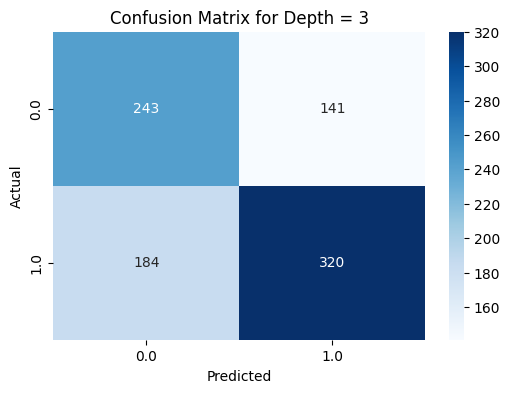

Results for Decision Tree with depth = 6:
Accuracy: 63.8514%
Precision: 68.0473%
Recall: 68.4524%
F1 Score: 68.2493%


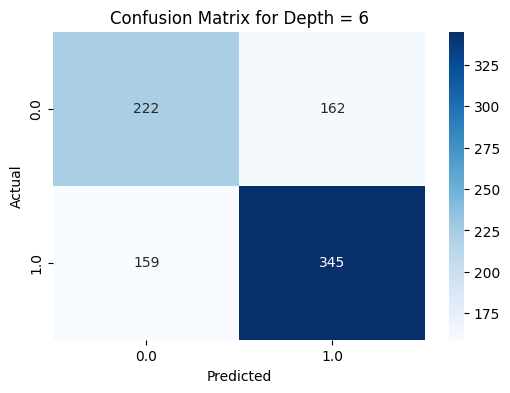

Results for Decision Tree with depth = 9:
Accuracy: 63.9640%
Precision: 71.9048%
Recall: 59.9206%
F1 Score: 65.3680%


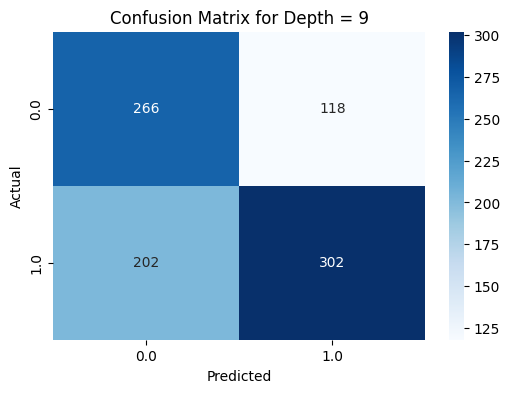

The best model is the Decision Tree with depth = 6, based on F1-score.


In [6]:
confusion_matrices = {}
metrics = {}

# Evaluate models on validation dataset
for i, depth in enumerate(depths):
    # Get the model trained with the current depth
    tree = trees[i]['model']  # Access the 'model' key from the dictionary
    
    # Make predictions on the validation dataset
    y_val_pred = tree.predict(X_val)
    
    # Get the correct labels for your dataset (e.g., 'yes', 'no' or [0, 1])
    unique_labels = np.unique(y_val)
    
    # Compute confusion matrix with the actual labels
    cm = confusion_matrix(y_val, y_val_pred, labels=unique_labels)
    confusion_matrices[depth] = cm
    
    # Calculate accuracy, precision, recall, F1-score (adjust pos_label to match your positive class)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, pos_label=unique_labels[1])  # Adjust as needed
    recall = recall_score(y_val, y_val_pred, pos_label=unique_labels[1])        # Adjust as needed
    f1 = f1_score(y_val, y_val_pred, pos_label=unique_labels[1])                # Adjust as needed
    
    # Store the metrics for each depth
    metrics[depth] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Display the results
    print(f"Results for Decision Tree with depth = {depth}:")
    print(f"Accuracy: {accuracy:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1 Score: {f1:.4%}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(f'Confusion Matrix for Depth = {depth}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Choose the best model based on F1-score (or any other metric)
best_depth = max(metrics, key=lambda x: metrics[x]['f1'])
best_model = trees[depths.index(best_depth)]['model']

print(f"The best model is the Decision Tree with depth = {best_depth}, based on F1-score.")

# **Feature Importance**

Utilizando o melhor modelo gere o gráfico de importância das features para o modelo que obteve o melhor desempenho nos dados de validação. Em seguida, **remova as** **cinco** **features com menor importância e treine o modelo com o conjunto de treino novamente.**

**Dica**

- Utilize o método `.feature_importances_` da biblioteca `sklearn` para obter os valores de importância de cada feature.



In [7]:
best_model = trees[1]['model']
feature_relevance = pd.DataFrame({'feature':df.columns.drop('y'),'value':best_model.feature_importances_})
feature_relevance.sort_values('value',ascending=False)

,feature,value
13,poutcome_success,0.288713
8,month,0.184931
3,balance,0.165236
4,housing,0.148978
0,age,0.104457
7,day,0.058652
10,previous,0.013137
9,campaign,0.012747
1,education,0.008077
6,contact,0.005334


In [8]:
columns_of_least_importance = ['poutcome_other','poutcome_failure','contact','education','campaign']


X_train.drop(columns=columns_of_least_importance, inplace=True)
X_val.drop(columns=columns_of_least_importance, inplace=True)
X_test.drop(columns=columns_of_least_importance, inplace=True)

for tree in trees:
    tree['model'] = tree['model'].fit(X_train,y_train)
    tree['pred'] = tree['model'].predict(X_val)

# **Avaliação do Novo Modelo**

Com as cinco features removidas, avalie novamente o modelo de árvore de decisão escolhido, utilizando apenas o **conjunto de validação**.

In [9]:
for i, tree in enumerate(trees):
    pred = tree['pred']
    accuracy = accuracy_score(y_val, pred)
    precision = precision_score(y_val, pred)
    recall = recall_score(y_val, pred)
    f1 = f1_score(y_val, pred)

    print(f"Results for Decision Tree with depth = {(i+1)*3}:")
    print(f"Accuracy: {accuracy:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1 Score: {f1:.4%}\n")

Results for Decision Tree with depth = 3:
Accuracy: 63.4009%
Precision: 69.4143%
Recall: 63.4921%
F1 Score: 66.3212%

Results for Decision Tree with depth = 6:
Accuracy: 63.6261%
Precision: 67.3040%
Recall: 69.8413%
F1 Score: 68.5492%

Results for Decision Tree with depth = 9:
Accuracy: 65.5405%
Precision: 73.4597%
Recall: 61.5079%
F1 Score: 66.9546%



# **Plotar a árvore do melhor modelo**

Gere a visualização da Árvore de Decisão do novo modelo

**Dica:**

- Use a função `plot_tree()` da biblioteca `sklearn`

- Para tornar a visualização mais clara e facilitar a interpretação dos resultados, ajuste o parâmetro max_depth em `plot_tree(max_depth=?)`, limitando a profundidade da árvore exibida e destacando os nós mais significativos.

Plot do melhor modelo


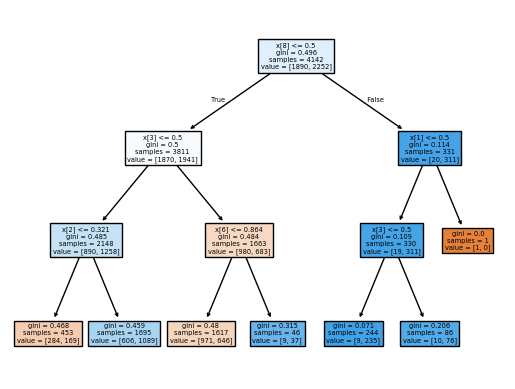

In [10]:
plot_tree(trees[0]['model'], max_depth=3, filled=True)
plt.savefig('decision_tree.svg', format='svg')
print("Plot do melhor modelo")

# **Criação de Exemplos Fictícios**

Observe a estrutura da árvore de decisão treinada e crie dois exemplos fictícios, um para cada possível valor do target. Para cada exemplo, descreva detalhadamente o caminho que ele seguirá na árvore, ou seja, a sequência de nós que serão percorridos até chegar à folha correspondente.

In [11]:
test_df = pd.DataFrame(data={
    'age': [42, 35], 
    'education': ['tertiary', 'primary'], 
    'default': ['yes', 'no'], 
    'balance': [1568, 890], 
    'housing': ['yes', 'yes'],
    'loan': ['no', 'no'], 
    'contact': ['cellular', 'telephone'], 
    'day': [29, 3], 
    'month': ['jan', 'dec'], 
    'campaign': [2, 1], 
    'previous': [0, 5], 
    'poutcome': ['success', 'success'],
    'y': ['yes', 'no']
})


In [12]:
# treating outliers
for column in ['age', 'balance', 'day', 'campaign', 'previous']:
    Q1 = test_df[column].quantile(0.25)
    Q3 = test_df[column].quantile(0.75)
    IQR = Q3 - Q1
    test_df = test_df[(test_df[column] < (Q3 + 1.5 * IQR)) & (test_df[column] > (Q1 - 1.5 * IQR))]

test_df.loc[test_df['education'] == 'unknown', 'education'] = 'secondary'    

test_df['education'] = oe_education.transform(test_df[['education']])
test_df['month'] = oe_month.transform(test_df[['month']])

test_df['default'] = le_default.transform(test_df['default'])
test_df['housing'] = le_housing.transform(test_df['housing'])
test_df['loan'] = le_loan.transform(test_df['loan'])
test_df['contact'] = le_contact.transform(test_df['contact'])
test_df['y'] = le_y.fit_transform(test_df['y'])

poutcome = ohe.transform(test_df[['poutcome']])
test_df_poutcome = pd.DataFrame(poutcome, columns=ohe.get_feature_names_out(['poutcome']))
test_df.drop(columns=['poutcome'], axis = 1, inplace = True)
test_df.reset_index(drop=True, inplace=True)
test_df_poutcome.reset_index(drop=True, inplace=True)
test_df = pd.concat([test_df, test_df_poutcome], axis = 1)

test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

test_df.drop(columns=columns_of_least_importance, inplace=True)

test_df.head(10)

,age,default,balance,housing,loan,day,month,previous,y,poutcome_success
0,0.413793,1.0,0.558048,1.0,0.0,0.933333,0.363636,0.0,1.0,1.0
1,0.293103,0.0,0.450956,1.0,0.0,0.066667,0.181818,2.5,0.0,1.0


### Explicação do caminho:
Ambos os exemplos têm poutcome = success, o que fará com que caiam no galho à direita. Em seguida, o primeiro exemplo cairá na folha laranja à direita, pois tem default = yes, fazendo com que o modelo faça uma previsão de que y = no com gini = 0. Enquanto isso, o segundo exemplo cairá no galho à esquerda, pois tem default = 0, e por fim na folha azul à direita, pois housing = yes, fazendo com que o modelo faça a previsão y = yes, com gini = 0.206.

# **Inferência e Verificação**

Realize uma inferência utilizando esses dois exemplos fictícios no modelo treinado. Verifique se os resultados obtidos na inferência correspondem aos valores do target que você imaginou ao criar os exemplos.

In [13]:
trees[0]['model'].predict(test_df.drop(columns=['y']))

array([0., 1.])

Realmente deu o esperado, 0 sendo no e 1 sendo yes.

# **Escolha do melhor modelo**

Selecione o melhor modelo até agora com base no desempenho no conjunto de validação durante a etapa de avaliação e faça uma avaliação final do desempenho utilizando o **conjunto de** **teste**.

In [14]:
# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate metrics for the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Performance on the Test Set:")
print(f"Test Accuracy: {test_accuracy:.4%}")
print(f"Test Precision: {test_precision:.4%}")
print(f"Test Recall: {test_recall:.4%}")
print(f"Test F1 Score: {test_f1:.4%}")

Performance on the Test Set:
Test Accuracy: 62.1622%
Test Precision: 65.6687%
Test Recall: 66.7343%
Test F1 Score: 66.1972%


# **Mostre uma análise comparativa entre validação e teste para o modelo escolhido**

**Observação:** Se houver uma discrepância muito grande nos resultados, algo pode estar errado, verifique seu treinamento e avaliação do modelo.

In [16]:
validation_scores = metrics[3]
comparacao = pd.DataFrame({'test':[test_accuracy, test_precision, test_recall, test_f1], 'validation':validation_scores.values()}, index=['accuracy','precision','recall','f1 score'])

comparacao['diferenca'] = comparacao['test'] - comparacao['validation']

comparacao

,test,validation,diferenca
accuracy,0.621622,0.634009,-0.012387
precision,0.656687,0.694143,-0.037457
recall,0.667343,0.634921,0.032422
f1 score,0.661972,0.663212,-0.001241
